# Global Temperature Change Analysis
We analize the annual global mean temperature anomalies provided by the [Goddard Institute for Space Studies (GISS)](https://data.giss.nasa.gov/gistemp/). The [dataset](https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv) is available for download as CSV file from the GISS website.

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from osgeo import gdal, osr, ogr
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("Python version: %s"%python_version())
print("NumPy version: %s"%np.__version__)
print("Pandas version: %s"%pd.__version__)
print('GDAL version: %s'%gdal.__version__)
print("GeoPandas version: %s"%gpd.__version__)

Python version: 3.11.5
NumPy version: 1.25.2
Pandas version: 2.1.1
GDAL version: 3.7.2
GeoPandas version: 0.14.0


In [24]:
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
ds_path = 'data/GLB.Ts+dSST.csv'
giss_temp = pd.read_csv(ds_path, header=1)
giss_temp.head(2)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.19,-0.24,-0.09,-0.16,-0.10,-0.21,-0.18,-0.10,-0.14,-0.23,-0.21,-0.18,-0.17,***,***,-0.12,-0.16,-0.19
1,1881,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-.10,-.17,0.05,-0.08,-0.19


In [27]:
year_index = pd.date_range('1880', '2024', freq='Y')
#giss_temp.drop(giss_temp.tail(1).index,inplace=True)
#giss_temp['Dec'] = pd.to_numeric(giss_temp['Dec'])
giss_temp.set_index(year_index, inplace=True)
giss_temp.drop('Year', axis=1, inplace=True)
giss_temp.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
1880-12-31,-0.19,-0.24,-0.09,-0.16,-0.10,-0.21,-0.18,-0.10,-0.14,-0.23,-0.21,-0.18,-0.17,***,***,-0.12,-0.16,-0.19
1881-12-31,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-.10,-.17,0.05,-0.08,-0.19


In [28]:
annual_mean = []
for index, row in giss_temp.iterrows():
    sum = 0
    months = 0
    for col in giss_temp.columns[0:12]:
        sum += row[col]  
    annual_mean.append(round(sum / 12, 2))

In [29]:
giss_temp['Annual Mean'] = annual_mean
giss_temp.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean
1880-12-31,-0.19,-0.24,-0.09,-0.16,-0.10,-0.21,-0.18,-0.10,-0.14,-0.23,-0.21,-0.18,-0.17,***,***,-0.12,-0.16,-0.19,-0.17
1881-12-31,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-.10,-.17,0.05,-0.08,-0.19,-0.09


## Uncertainty
The uncertainty is provided in an additional [file](https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/totalCI_ERA.csv) available from the [GISS](https://data.giss.nasa.gov/gistemp/graphs_v4/) website

In [36]:
url_error_data = 'https://data.giss.nasa.gov/gistemp/graphs_v4/graph_data/totalCI_ERA.csv'
error_data = pd.read_csv(url_error_data)
error_data['ci95'].astype(float)
error = error_data['ci95']
error_data['ci95'] = error.apply(lambda error: round(error, 2)) 
error_data.tail(2)

,year,ci95
142,2022,0.05
143,2023,0.05


In [37]:
giss_temp['Uncertainty'] = error_data['ci95'].tolist()
giss_temp['Uncertainty']
giss_temp.head(2)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON,Annual Mean,Uncertainty
1880-12-31,-0.19,-0.24,-0.09,-0.16,-0.10,-0.21,-0.18,-0.10,-0.14,-0.23,-0.21,-0.18,-0.17,***,***,-0.12,-0.16,-0.19,-0.17,0.14
1881-12-31,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.04,-0.15,-0.22,-0.19,-0.07,-0.09,-.10,-.17,0.05,-0.08,-0.19,-0.09,0.13


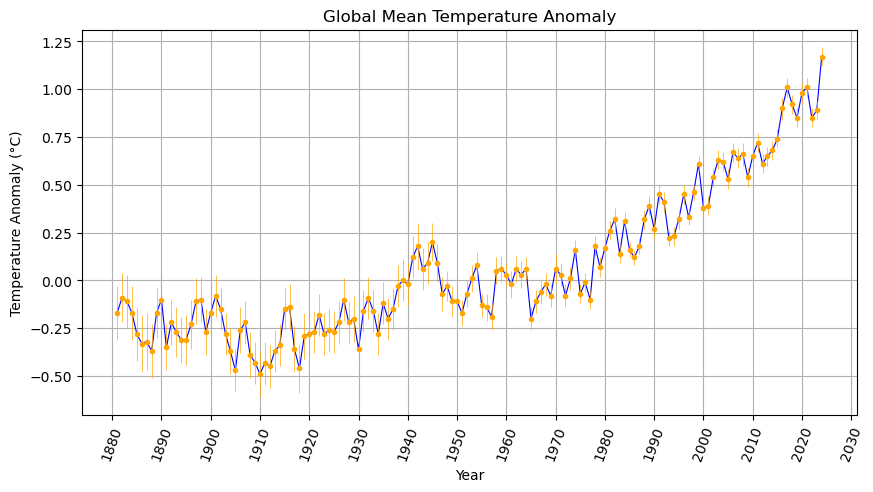

In [38]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Mean Temperature Anomaly')
ax.set_ylabel('Temperature Anomaly (°C)')
ax.set_xlabel('Year')
ax.set_xticks(giss_temp.index)
ax.set_xticklabels(giss_temp.index, rotation=70)
ax.xaxis.set_major_locator(dates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_giss_temp = ax.plot(giss_temp['Annual Mean'], linewidth=0.8, label='temp.anom', color='blue')
plt_giss_error= ax.errorbar(giss_temp.index, giss_temp['Annual Mean'], yerr=giss_temp['Uncertainty'], linewidth=0.5, color='orange', fmt='.k');
#plt.legend(loc='upper left')
plt.savefig('giss_anomaly.png', dpi=300)

In [39]:
ADF_result = adfuller(giss_temp['Annual Mean'])
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: 1.4641340696516245
p-value: 0.9973868775709003


In [42]:
giss_temp_diff = np.diff(giss_temp['Annual Mean'], n=1)
giss_temp_diff_df = pd.DataFrame({'Diff': giss_temp_diff}, index=year_index[1:])

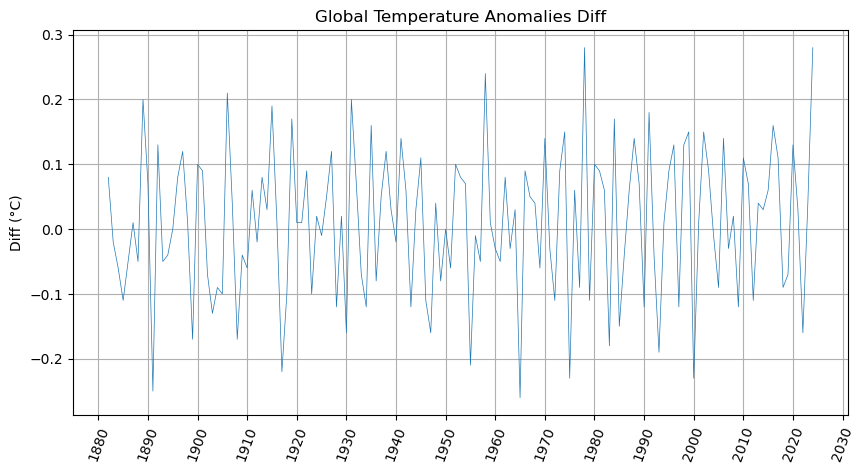

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ax.grid(True)
ax.set_title('Global Temperature Anomalies Diff')
ax.set_ylabel('Diff (°C)')
ax.set_xticks(giss_temp_diff_df.index)
ax.set_xticklabels(giss_temp_diff_df.index, rotation=70)
ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt_google_diff = ax.plot(giss_temp_diff_df, linewidth=0.5, label='anom.diff')
#plt.legend(loc='upper left')

In [44]:
ADF_result = adfuller(giss_temp_diff_df)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -7.562154289780749
p-value: 2.990356395695225e-11


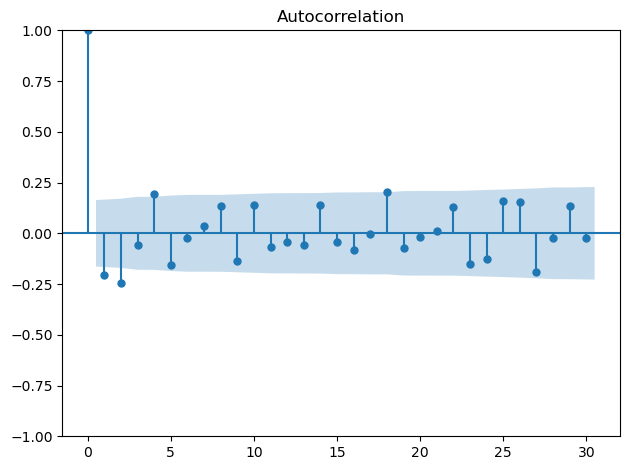

In [45]:
plot_acf(giss_temp_diff_df, lags=30)
plt.tight_layout()